In [1]:
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/preprocessed-data/LIOC_pca.csv
/kaggle/input/preprocessed-data/btc_pca.csv
/kaggle/input/preprocessed-data/eth_pca.csv
/kaggle/input/preprocessed-data/EXPO_pca.csv
/kaggle/input/preprocessed-data/ltc_pca.csv


# Data Import

In [3]:
df=pd.read_csv("/kaggle/input/preprocessed-data/btc_pca.csv")
df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca11,pca13,pca14,pca16,pca17,pca18,pca19,pca20,pca21,Close
0,8.744221,-0.658155,-1.093340,1.176938,-0.600751,0.026237,-0.359053,0.953242,-0.384168,-0.651644,1.318398,-1.074751,-0.619783,0.330380,0.079497,-0.023768,-0.397569,13761.50
1,8.735730,-1.444550,-0.894045,1.317192,-0.625199,0.668508,0.187651,0.723749,0.073215,-2.282633,0.713949,-1.182119,-0.148796,0.673623,0.072780,-0.063445,-0.497342,13792.66
2,8.766185,-1.117762,-0.750429,0.095987,-0.725724,0.366221,0.253420,0.077264,1.710729,0.324876,-0.788650,-1.095183,-0.214677,0.895774,0.097829,-0.167460,-0.486162,13792.35
3,8.713572,-1.480208,-1.114621,0.445480,-0.911416,2.514267,0.581901,-0.143601,0.889499,-0.816233,-0.254987,-1.091789,-0.075686,0.902458,0.077003,-0.013148,-0.541326,13799.99
4,8.754863,-1.396565,-0.814961,0.131886,-0.800946,3.031047,0.010632,1.081172,-0.577558,-0.129734,0.952726,-1.102891,-0.133230,0.951209,0.096098,-0.127653,-0.519283,13800.65


In [4]:
def NaNCheck(data):
  return data.isnull().sum()[data.isnull().sum()>0]

# WGAN Model

In [5]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad as torch_grad
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

#### Sliding Window

In [6]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

tmp_x = [0,1,2,3,4]

tmp_y = [5]

tmy_y_gan = [0,1,2,3,4,5]

#### HyperParameters

In [7]:
sliding_window_size = 10
testing_duration = 2016
training_duration = 2016

#### Train Test Split

In [8]:
labels_df = df["Close"]
features_df = df.drop(columns=["Close"])

train_x = features_df.iloc[:training_duration]
train_y = labels_df.iloc[:training_duration]

test_x = features_df.iloc[training_duration:training_duration+testing_duration]
test_y = labels_df.iloc[training_duration:training_duration+testing_duration]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (2016, 17) trainY: (2016,)
testX: (2016, 17) testY: (2016,)


In [9]:
x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.values.reshape(-1, 1))
test_y = y_scaler.transform(test_y.values.reshape(-1, 1))

In [10]:
print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (2016, 17) trainY: (2016, 1)
testX: (2016, 17) testY: (2016, 1)


In [11]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, sliding_window_size)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, sliding_window_size)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')

train_x: torch.Size([2006, 10, 17]) train_y: torch.Size([2006, 1]) train_y_gan: torch.Size([2006, 11, 1])
test_x: torch.Size([2006, 10, 17]) test_y: torch.Size([2006, 1]) test_y_gan: torch.Size([2006, 11, 1])


## Model Implementation

In [12]:
class Generator(nn.Module):
  def __init__(self, input_size):
    super().__init__()

    # 3 GRU layers, input_size = features
    self.gru_1 = nn.GRU(input_size, 1024, batch_first=True)
    self.gru_2 = nn.GRU(1024, 512, batch_first = True)
    self.gru_3 = nn.GRU(512, 256, batch_first = True)
    # 3 Dense Layers
    self.linear_1 = nn.Linear(256, 128)
    self.linear_2 = nn.Linear(128, 64)
    self.linear_3 = nn.Linear(64, 1)

    self.dropout = nn.Dropout(0.2)


  def forward(self, x):
    use_cuda = 1
    device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
    h0 = torch.zeros(1, x.size(0), 1024).to(device) # initial hidden state for the 1st GRU Layer - (num of layers in the GRU, batch size, num of hidden units in the GRU)
    out_gru_1, _ = self.gru_1(x, h0)
    out_gru_1 = self.dropout(out_gru_1)

    h1 = torch.zeros(1, x.size(0), 512).to(device)
    out_gru_2, _ = self.gru_2(out_gru_1, h1)
    out_gru_2 = self.dropout(out_gru_2)

    h2 = torch.zeros(1, x.size(0), 256).to(device)
    out_gru_3, _ = self.gru_3(out_gru_2, h2)
    out_gru_3 = self.dropout(out_gru_3)

    out_dense_1 = self.linear_1(out_gru_3[:, -1, :])
    out_dense_2 = self.linear_2(out_dense_1)
    out_dense_3 = self.linear_3(out_dense_2)
    
    return out_dense_3

In [13]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    # 3 1D Conv layers
    self.conv1 = nn.Conv1d(sliding_window_size+1, 32, kernel_size = 5, stride = 1, padding = 'same')
    self.conv2 = nn.Conv1d(32, 64, kernel_size = 5, stride = 1, padding = 'same')
    self.conv3 = nn.Conv1d(64, 128, kernel_size = 5, stride = 1, padding = 'same')

    # 3 linear layers
    self.linear1 = nn.Linear(128, 220)
    self.linear2 = nn.Linear(220, 220)
    self.linear3 = nn.Linear(220, 1)

    self.leaky = nn.LeakyReLU(0.01)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, x):
    conv1 = self.conv1(x)
    conv1 = self.leaky(conv1)
    conv2 = self.conv2(conv1)
    conv2 = self.leaky(conv2)
    conv3 = self.conv3(conv2)
    conv3 = self.leaky(conv3)

    flatten_x =  conv3.reshape(conv3.shape[0], conv3.shape[1])

    out_1 = self.linear1(flatten_x)
    out_1 = self.leaky(out_1)
    out_2 = self.linear2(out_1)
    out_2 = self.relu(out_2)
    out_3 = self.linear3(out_2)

    return out_3

In [14]:
def grad_penalty_fnc(real_data, gen_data,D,cuda,gp_weight):
    batch_size = real_data.size()[0]
    t = torch.rand((batch_size, 1, 1), requires_grad=True)
    t = t.expand_as(real_data)

    if cuda:
        t = t.cuda()

    # mixed sample from real and fake; make approx of the 'true' gradient norm
    interpol = t * real_data.data + (1-t) * gen_data.data

    if cuda:
        interpol = interpol.cuda()
    prob_interpol = D(interpol)
    torch.autograd.set_detect_anomaly(True)
    gradients = torch_grad(outputs=prob_interpol, inputs=interpol,
                           grad_outputs=torch.ones(prob_interpol.size()).cuda() if cuda else torch.ones(
                               prob_interpol.size()), create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(batch_size, -1)
    #grad_norm = torch.norm(gradients, dim=1).mean()
    #self.losses['gradient_norm'].append(grad_norm.item())

    # add epsilon for stability
    eps = 1e-10
    gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1, dtype=torch.double) + eps)
    #gradients = gradients.cpu()
    # comment: precision is lower than grad_norm (think that is double) and gradients_norm is float
    final = gp_weight * (torch.max(torch.zeros(1,dtype=torch.double).cuda() if cuda else torch.zeros(1,dtype=torch.double), gradients_norm.mean() - 1) ** 2), gradients_norm.mean().item()
    return final


In [15]:
use_cuda = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
print(device)

cuda


In [16]:
batch_size = 128
learning_rate = 0.000115
num_epochs = 1000
critic_iterations = 5

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

# Give number of features to the G
modelG = Generator(train_x.shape[1]).to(device)
modelD = Discriminator().to(device)

#weight_decay-L2 penalty to the weights
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)

# optimizerG = torch.optim.RMSprop(modelG.parameters(), lr = learning_rate, weight_decay = 1e-3)
# optimizerD = torch.optim.RMSprop(modelD.parameters(), lr = learning_rate, weight_decay = 1e-3)

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0

#k=0
i=0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)
    
        fake_data = modelG(x)
        i=1
        fake_data = torch.cat([y[:, :sliding_window_size, :], fake_data.reshape(-1, 1, 1)], axis = 1)
        
        for _ in range(critic_iterations):
            critic_real = modelD(y)
            critic_fake = modelD(fake_data)
            grad_penalty, grad_norm_ = grad_penalty_fnc(y, fake_data,modelD,cuda,10)
            # Take probability mean of whole batch.
            lossD = -(torch.mean(critic_real) - torch.mean(critic_fake)) + grad_penalty

            modelD.zero_grad()
            lossD.backward(retain_graph = True)
            optimizerD.step()
    
        output_fake = modelD(fake_data)
        lossG = -torch.mean(output_fake)

        modelG.zero_grad() # zeroing the gradients
        lossG.backward() # computing the gradients
        optimizerG.step() # updating the parameters

        loss_D.append(lossD.item())
        loss_G.append(lossG.item())
    
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/1000] LossD: -0.0476912222802639 LossG:-0.9146805480122566
[2/1000] LossD: 0.007644489407539368 LossG:-0.9849552884697914
[3/1000] LossD: 0.004059024155139923 LossG:-0.4797278679907322
[4/1000] LossD: -0.01697561703622341 LossG:-0.37451181188225746
[5/1000] LossD: -0.03277465142309666 LossG:-0.5018622893840075
[6/1000] LossD: -0.11415164731442928 LossG:-0.4485122859477997
[7/1000] LossD: -0.4821526575833559 LossG:-0.39755268197041005
[8/1000] LossD: -1.2684684470295906 LossG:-0.42503375094383955
[9/1000] LossD: -3.16607831578931 LossG:0.16565306694246829
[10/1000] LossD: -3.9749441134592325 LossG:-0.5127561520785093
[11/1000] LossD: -4.264455404448083 LossG:-0.7215060386806726
[12/1000] LossD: -4.3650478926135685 LossG:-0.9906409718096256
[13/1000] LossD: -4.5062938891447715 LossG:-0.8846249561756849
[14/1000] LossD: -4.206021533306276 LossG:-1.2752574319019914
[15/1000] LossD: -4.04311145168011 LossG:-1.626682823523879
[16/1000] LossD: -3.8998920932876295 LossG:-2.0243804903002456


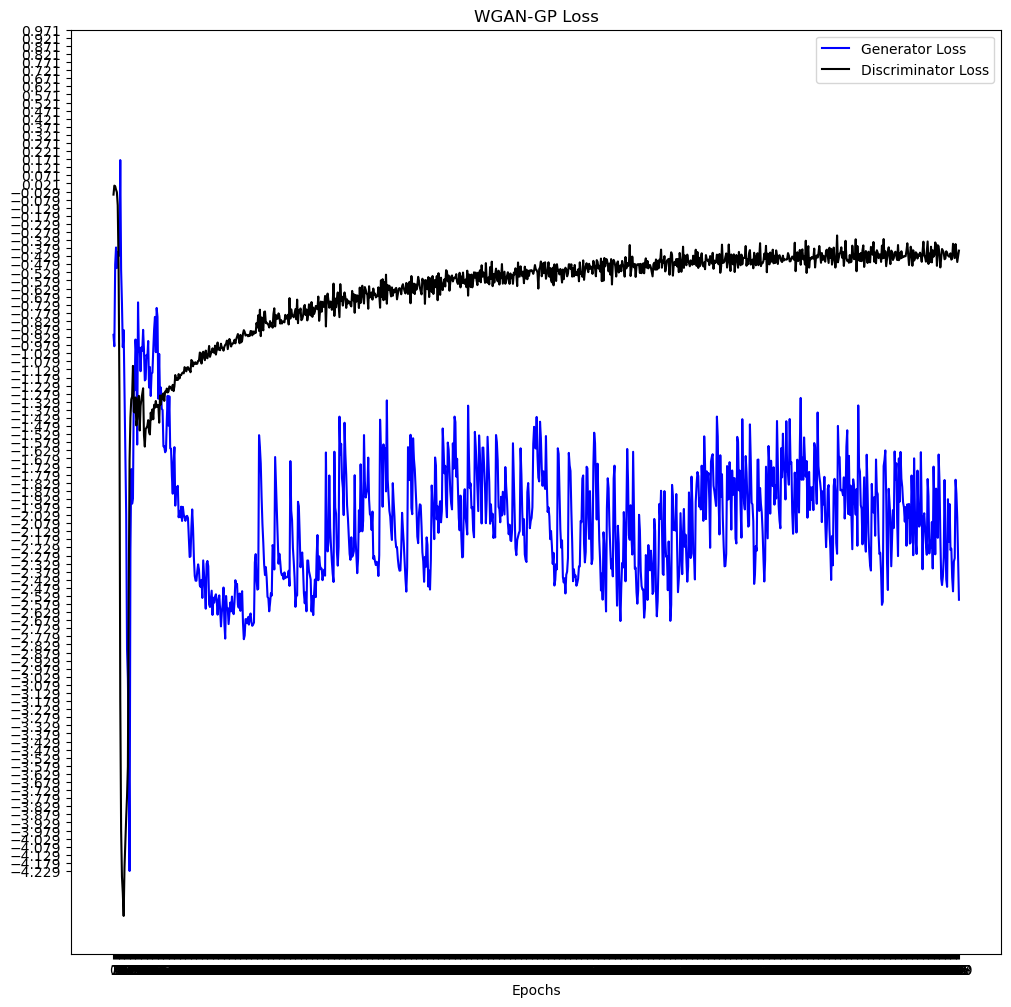

In [17]:
plt.figure(figsize = (12, 12))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.xticks(np.arange(0, num_epochs, 1.0))
plt.yticks(np.arange(min(histG), 1, 0.05))
plt.title('WGAN-GP Loss')
plt.xlabel('Epochs')
plt.legend(loc = 'upper right')

In [18]:
train_y_slide.shape

torch.Size([2006, 1])

In [19]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:134.5147249267873


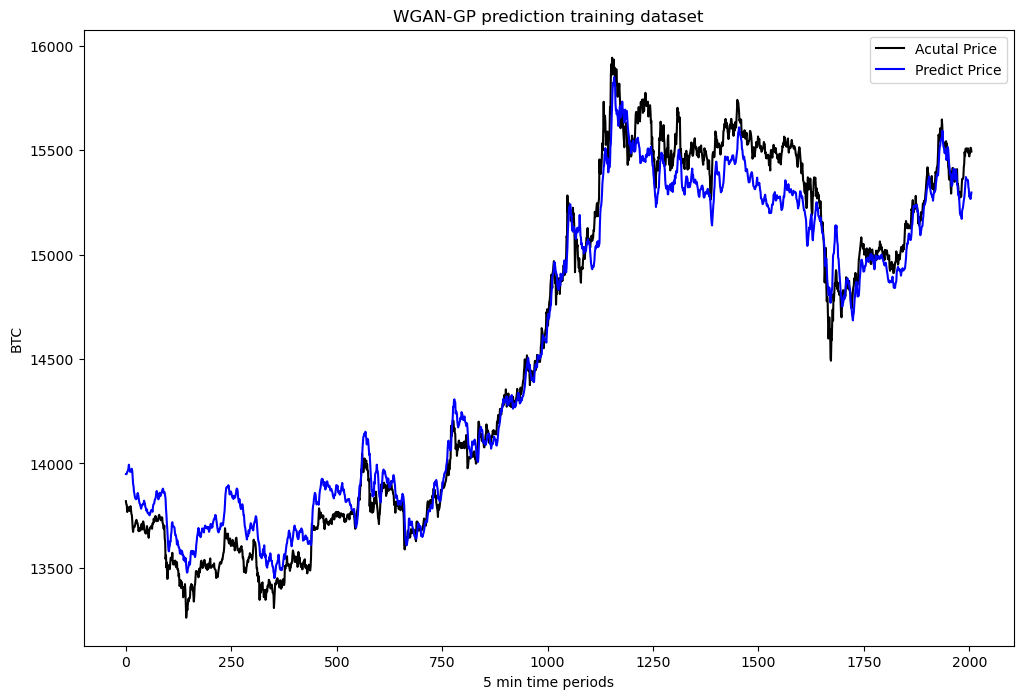

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction training dataset')
plt.ylabel('BTC')
plt.xlabel('5 min time periods')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Testing dataset RMSE:241.89004400459268


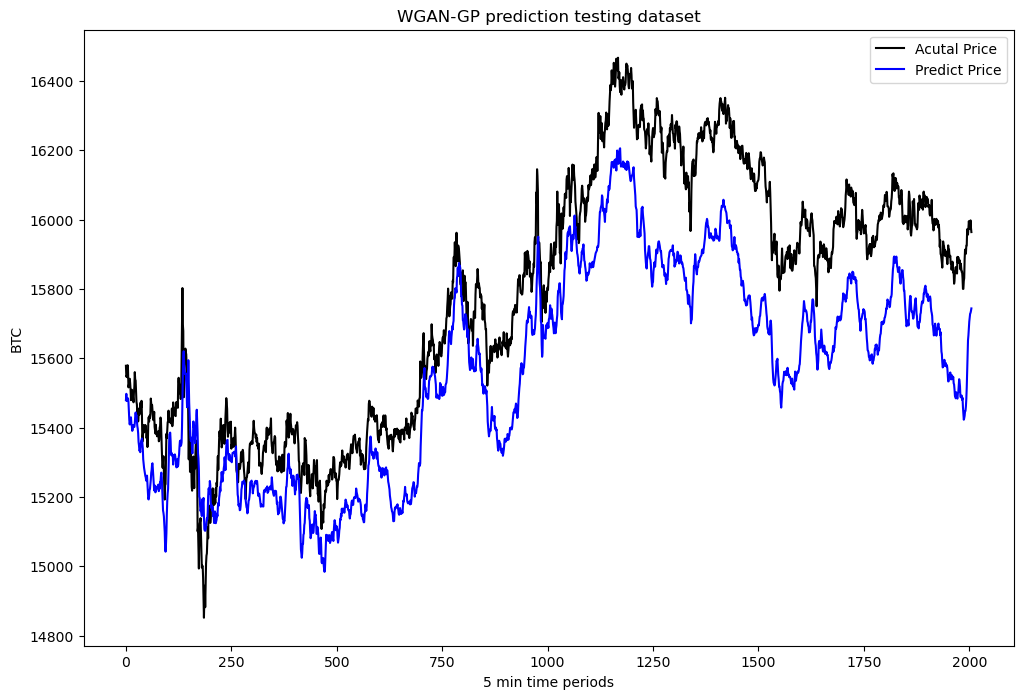

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP prediction testing dataset')
plt.ylabel('BTC')
plt.xlabel('5 min time periods')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Testing dataset RMSE:{RMSE}')